In [41]:
import pandas as pd
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from ipaddress import ip_address

In [42]:

# Step 1: Load the dataset
file_path = 'packet_data_copy.csv'  # Path to your CSV file
data = pd.read_csv(file_path)
data


,dest_mac,src_mac,eth_proto,IPV4,Protocol,version,header_length,ttl,src,target,packet_data9,packet_data10,packet_data11,packet_data12,packet_data13,packet_data14,packet_data15
0,52:54:00:12:35:02,08:00:27:40:3B:D0,8,IPV4,TCP,4,20,64,10.0.2.15,13.107.5.93,41510.0,443.0,2.176671e+09,7.133600e+04,"URG: 0, ACK: 1, PSH: 0, RST: 0, SYN: 0, FIN: 0",NaN,NaN
1,08:00:27:40:3B:D0,52:54:00:12:35:02,8,IPV4,TCP,4,20,64,13.107.5.93,10.0.2.15,443.0,41510.0,7.133600e+04,2.176671e+09,"URG: 0, ACK: 1, PSH: 0, RST: 0, SYN: 0, FIN: 0",NaN,\x00\x00\x00\x00\x00\x00
2,52:54:00:12:35:02,08:00:27:40:3B:D0,8,IPV4,TCP,4,20,64,10.0.2.15,152.199.4.33,46606.0,443.0,2.226724e+08,4.994660e+05,"URG: 0, ACK: 1, PSH: 0, RST: 0, SYN: 0, FIN: 0",NaN,NaN
3,08:00:27:40:3B:D0,52:54:00:12:35:02,8,IPV4,TCP,4,20,64,152.199.4.33,10.0.2.15,443.0,46606.0,4.994660e+05,2.226724e+08,"URG: 0, ACK: 1, PSH: 0, RST: 0, SYN: 0, FIN: 0",NaN,\x00\x00\x00\x00\x00\x00
4,52:54:00:12:35:02,08:00:27:40:3B:D0,8,IPV4,TCP,4,20,64,10.0.2.15,13.107.42.18,34592.0,443.0,1.732734e+09,1.191650e+06,"URG: 0, ACK: 1, PSH: 0, RST: 0, SYN: 0, FIN: 0",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,52:54:00:12:35:02,08:00:27:40:3B:D0,8,IPV4,TCP,4,20,64,10.0.2.15,20.50.201.195,57840.0,443.0,1.721453e+09,3.015476e+07,"URG: 0, ACK: 1, PSH: 1, RST: 0, SYN: 0, FIN: 0",\x17\x03\x03\x10\x6d\x73\x66\x1d\x63\x9c\x8b\x...,NaN
1555,08:00:27:40:3B:D0,52:54:00:12:35:02,8,IPV4,TCP,4,20,64,20.50.201.195,10.0.2.15,443.0,57840.0,3.015476e+07,1.721455e+09,"URG: 0, ACK: 1, PSH: 0, RST: 0, SYN: 0, FIN: 0",\x00\x00\x00\x00\x00\x00,NaN
1556,08:00:27:40:3B:D0,52:54:00:12:35:02,8,IPV4,TCP,4,20,64,20.50.201.195,10.0.2.15,443.0,57840.0,3.015476e+07,1.721456e+09,"URG: 0, ACK: 1, PSH: 0, RST: 0, SYN: 0, FIN: 0",\x00\x00\x00\x00\x00\x00,NaN
1557,08:00:27:40:3B:D0,52:54:00:12:35:02,8,IPV4,TCP,4,20,64,20.50.201.195,10.0.2.15,443.0,57840.0,3.015476e+07,1.721457e+09,"URG: 0, ACK: 1, PSH: 0, RST: 0, SYN: 0, FIN: 0",\x00\x00\x00\x00\x00\x00,NaN


In [43]:

# Step 2: Extract flag (e.g., ACK) from 'packet_data13' column
def extract_flag(packet_data, flag='ACK'):
    # Ensure packet_data is a string before applying regex
    if isinstance(packet_data, str):
        match = re.search(rf'{flag}: (\d)', packet_data)
        if match:
            return int(match.group(1))  # 1 if the flag is set, 0 otherwise
    return 0  # Return 0 if the flag is not found or if packet_data is not a string

# Step 3: Extract relevant features and clean the data
cleaned_data = []

for _, row in data.iterrows():
    # Extract packet size (using 'header_length')
    packet_size = row['header_length']
    
    # Convert Source IP to integer (use 'src' column)
    src_ip = ip_address(row['src']).packed
    src_ip_int = int.from_bytes(src_ip, 'big')
    
    # Convert Destination IP to integer (use 'target' column)
    dst_ip = ip_address(row['target']).packed
    dst_ip_int = int.from_bytes(dst_ip, 'big')
    
    # Extract Source Port (using 'packet_data9' column)
    src_port = row['packet_data9'] if 'packet_data9' in row else None
    
    # Extract Destination Port (using 'packet_data10' column)
    dst_port = row['packet_data10'] if 'packet_data10' in row else None
    

    cleaned_data.append([packet_size, src_ip_int, dst_ip_int, src_port, dst_port])


cleaned_df = pd.DataFrame(cleaned_data, columns=["Packet_Size", "Source_IP", "Destination_IP", "Source_Port", "Destination_Port"])

# Step 5: Extract ACK flag values and add as target column
cleaned_df['ACK'] = data['packet_data13'].apply(extract_flag, flag='ACK') 

cleaned_df
cleaned_df['ACK'].unique()

array([1, 0])

In [44]:
# Step 6: Handle missing values by dropping rows with missing data

cleaned_df = cleaned_df.dropna()
cleaned_df.isnull().sum()

Packet_Size         0
Source_IP           0
Destination_IP      0
Source_Port         0
Destination_Port    0
ACK                 0
dtype: int64

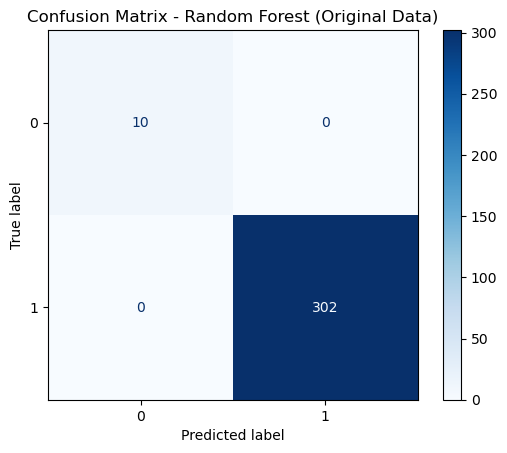

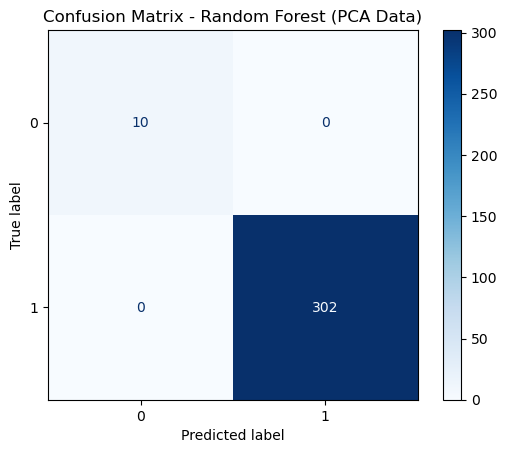

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00       302

    accuracy                           1.00       312
   macro avg       1.00      1.00      1.00       312
weighted avg       1.00      1.00      1.00       312

Classification Report (PCA Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00       302

    accuracy                           1.00       312
   macro avg       1.00      1.00      1.00       312
weighted avg       1.00      1.00      1.00       312



In [45]:

# Step 7: Prepare the features and target for classification
features = cleaned_df.drop('ACK', axis=1)  # Features excluding 'ACK'
target = cleaned_df['ACK']  # 'ACK' as the target variable

# Step 8: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 9: Train Random Forest Classifier on original features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 10: Predict and plot confusion matrix for original data
y_pred = rf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest (Original Data)")
plt.show()

# Step 11: Standardize the data for PCA (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Step 12: Apply PCA to reduce dimensionality (e.g., to 2 components for visualization)
pca = PCA(n_components=2)  # Reduce to 2 principal components
X_pca = pca.fit_transform(X_scaled)

# Step 13: Split the PCA-transformed data into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, target, test_size=0.2, random_state=42)

# Step 14: Train Random Forest Classifier on PCA-transformed data
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca, y_train_pca)

# Step 15: Predict and plot confusion matrix for PCA-transformed data
y_pred_pca = rf_pca.predict(X_test_pca)
conf_matrix_pca = confusion_matrix(y_test_pca, y_pred_pca)
disp_pca = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_pca)
disp_pca.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest (PCA Data)")
plt.show()

# Step 16: Print Classification Report for both models
print("Classification Report (Original Data):")
print(classification_report(y_test, y_pred))

print("Classification Report (PCA Data):")
print(classification_report(y_test_pca, y_pred_pca))


In [46]:
import joblib

# Save the trained RandomForest model (original data)
joblib.dump(rf, 'random_forest_model_original.pkl')

# Save the trained RandomForest model (PCA-transformed data)
joblib.dump(rf_pca, 'random_forest_model_pca.pkl')


['random_forest_model_pca.pkl']